# SDSS Galaxies vs Quasars

Tasks
- Create arrays for the (u-g), (g-r), (r-i), (i-z) colors. Also create an array with the class labels where galaxy=0 and quasar=1.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.

In [3]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
import matplotlib.pyplot as plt 
import seaborn as sns
from Utilities import plot_settings
import numpy as np
import pandas as pd

In [4]:
data_path = r'C:\Users\ricca\OneDrive\Documents\Data\galaxyquasar.csv'
data = pd.read_csv(data_path)

In [5]:
ug = (data['u'] - data['g']).to_numpy()
gr = (data['g'] - data['r']).to_numpy()
ri = (data['r'] - data['i']).to_numpy()
iz = (data['i'] - data['z']).to_numpy()

true_labels = np.where(data['class'].to_numpy() == 'QSO', 1, 0)

In [6]:
X = np.vstack([ug, gr, ri, iz]).T
y = true_labels

## Data exploration

In [7]:
from matplotlib.lines import Line2D

In [ ]:
df = pd.DataFrame(X, columns=['u-g', 'g-r', 'r-i', 'i-z'])
df['class'] = np.where(y == 1, 'QSO', 'non-QSO')

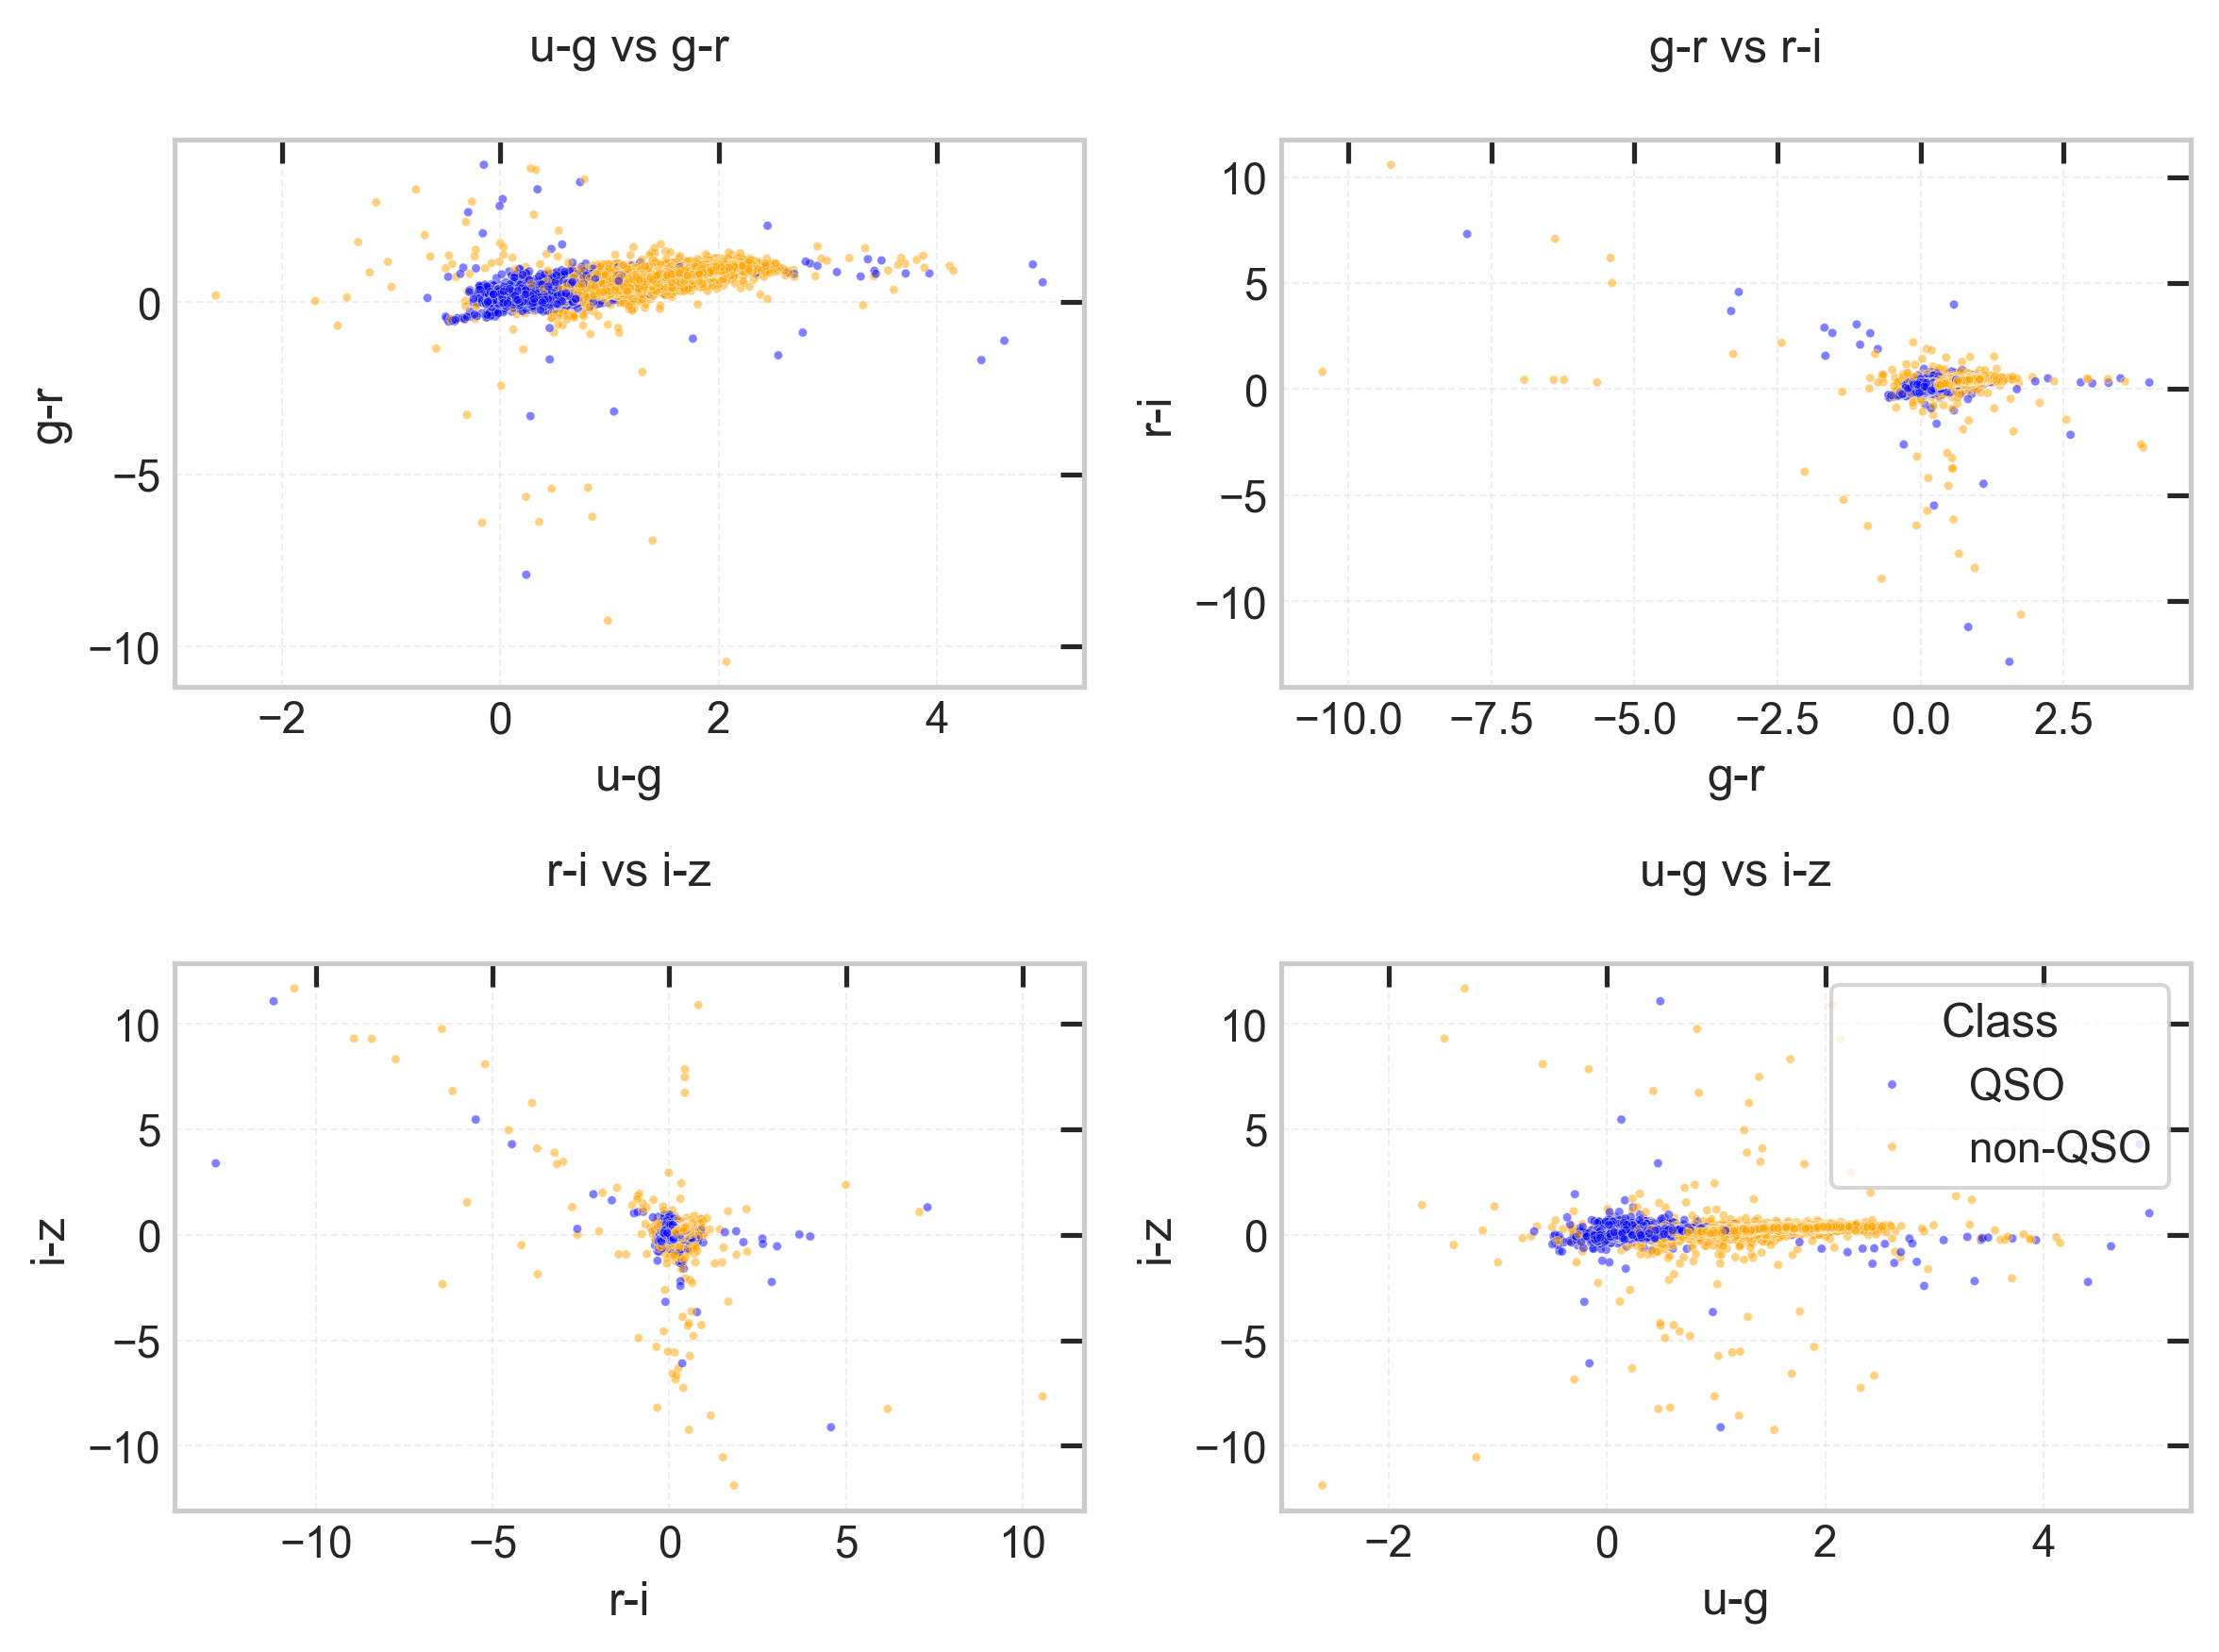

In [8]:
palette = {'non-QSO': 'orange', 'QSO': 'blue'}
sns.set_theme(style="whitegrid", rc={'figure.dpi': 300, 'savefig.dpi': 300})
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
sns.scatterplot(data=df, x='u-g', y='g-r', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('u-g vs g-r')

sns.scatterplot(data=df, x='g-r', y='r-i', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('g-r vs r-i')

sns.scatterplot(data=df, x='r-i', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('r-i vs i-z')

sns.scatterplot(data=df, x='u-g', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 1])
axs[1, 1].set_title('u-g vs i-z')

for ax in axs.flat:
    ax.tick_params(direction='in', top=True, right=True)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

handles, labels = axs[1, 1].get_legend_handles_labels()
axs[1, 1].legend(handles=handles, labels=labels, loc='upper right', title='Class')

plt.tight_layout()
plt.savefig("seaborn_color_color_qso_vs_nonqso.png", bbox_inches='tight')
plt.show()


Look at distribution of features

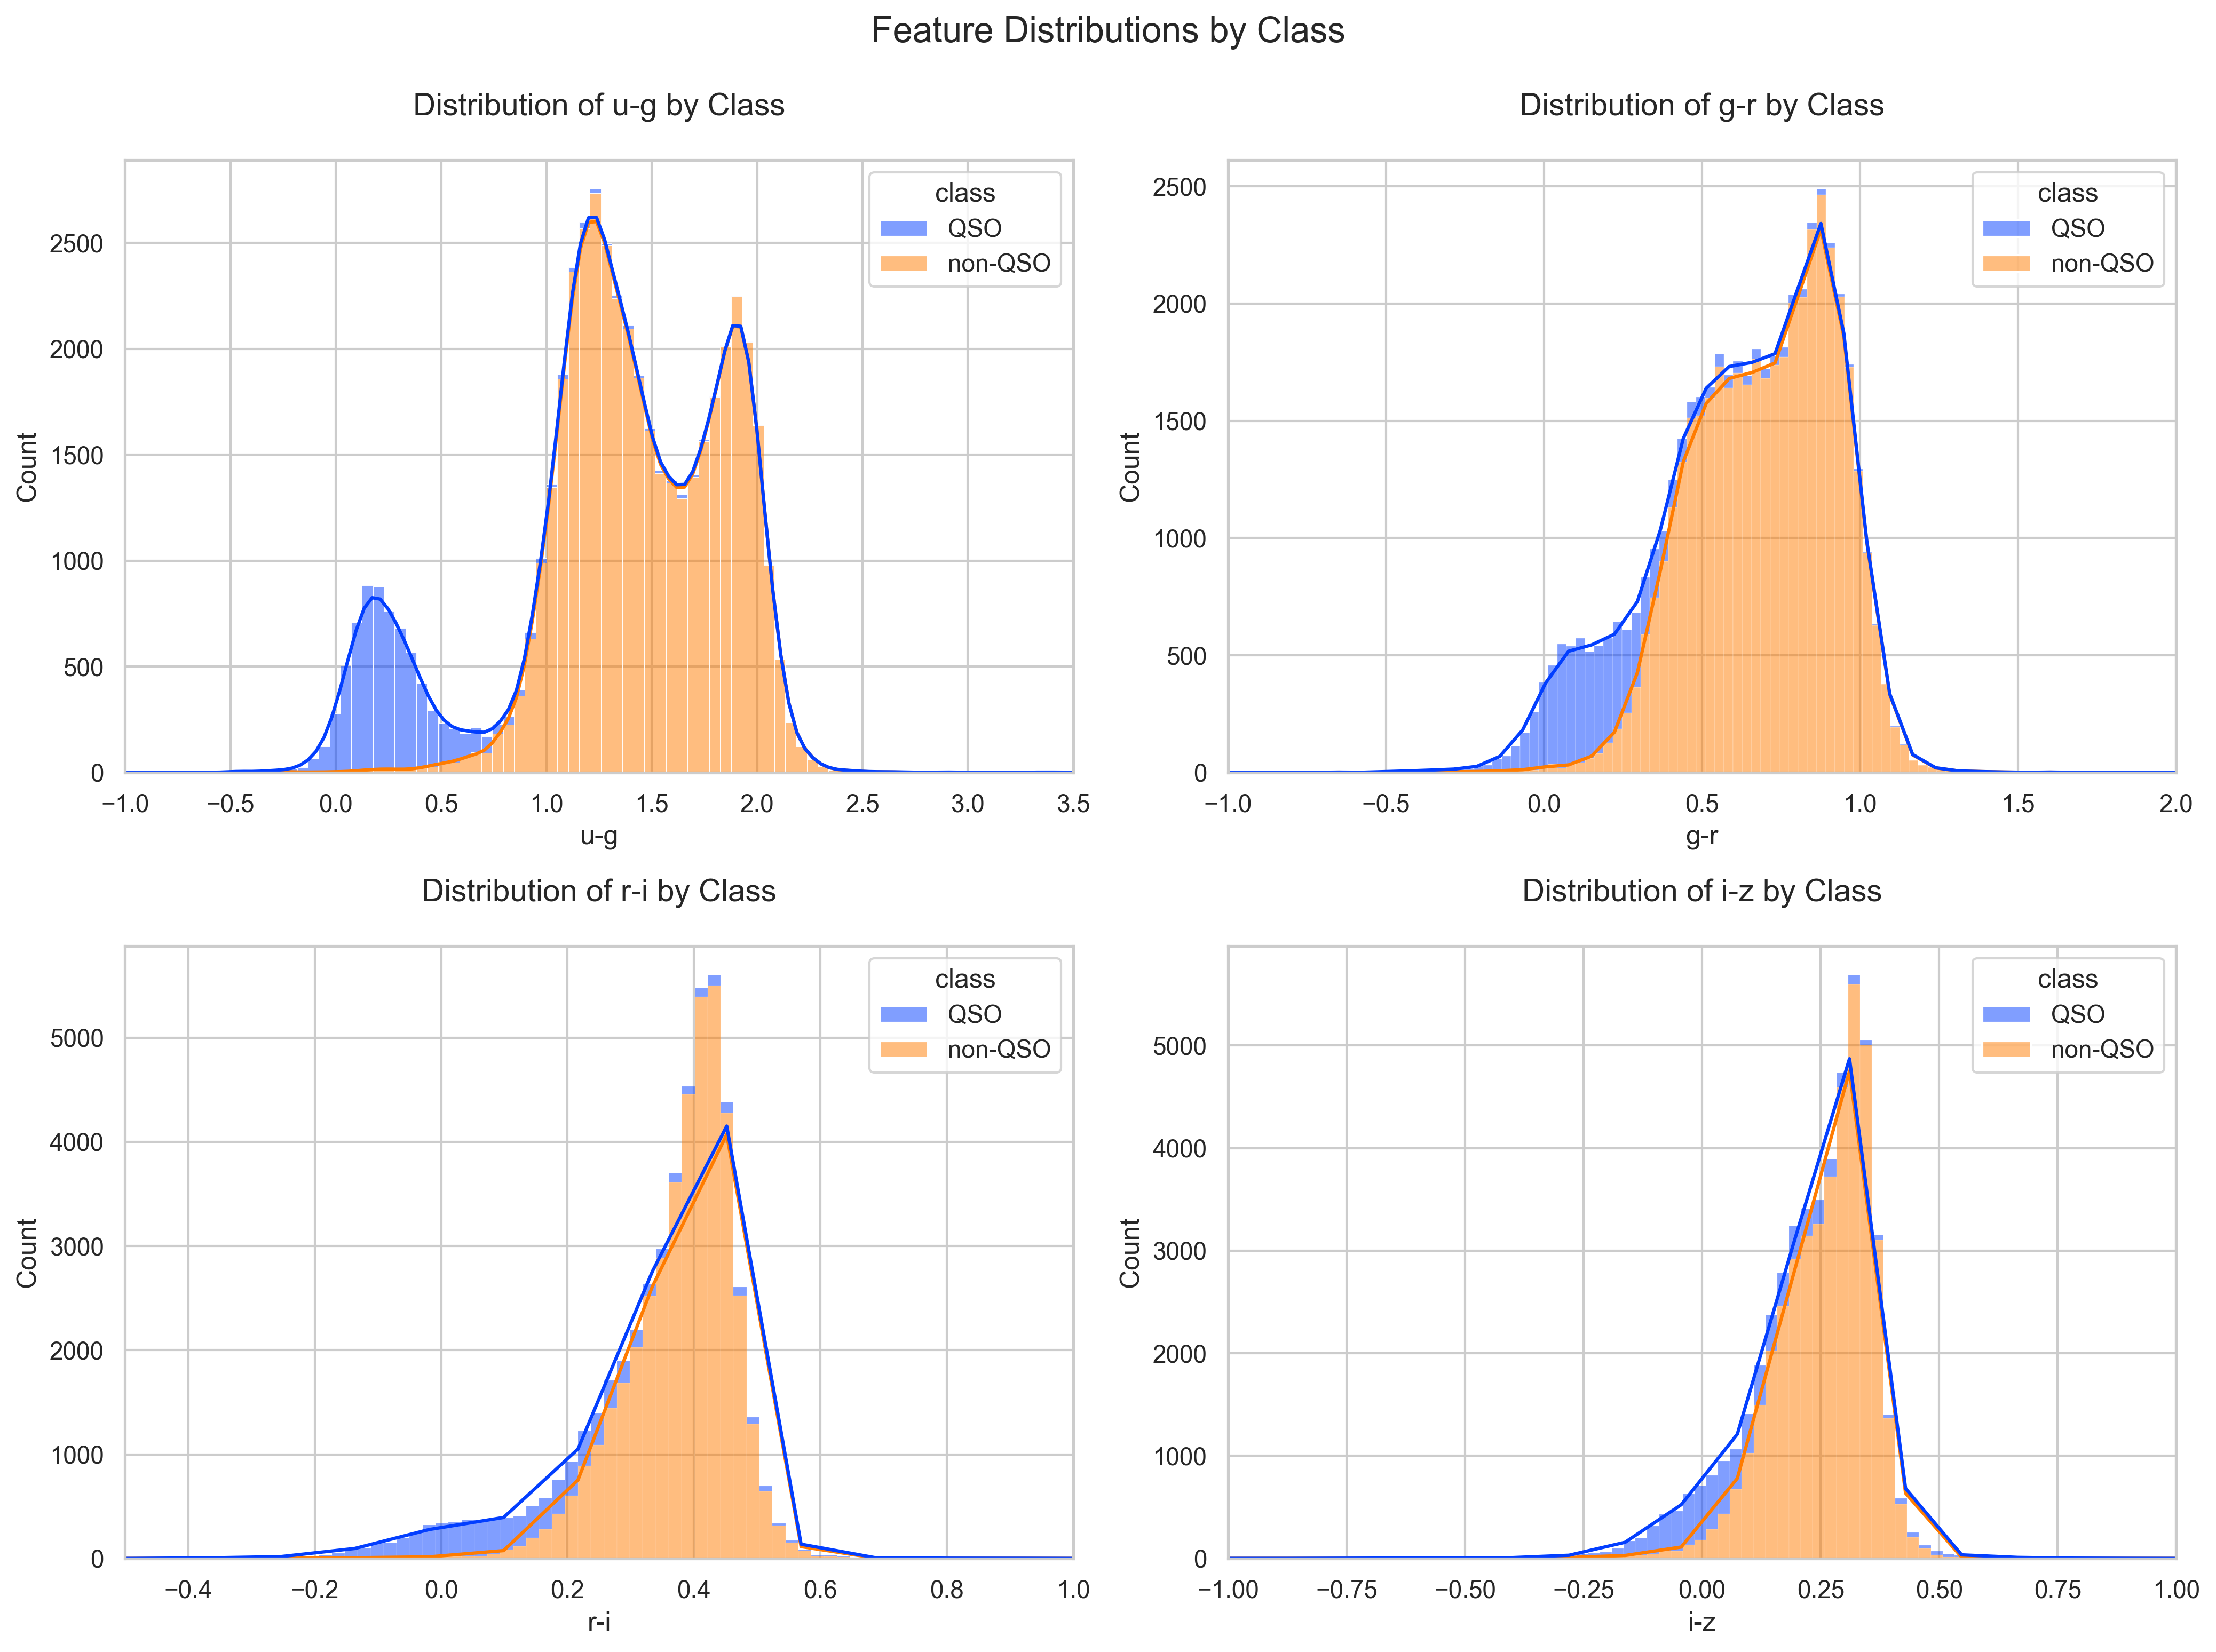

In [26]:
numeric_cols = ['u-g', 'g-r', 'r-i', 'i-z']
xlims = {
    'u-g': (-1, 3.5),
    'g-r': (-1, 2),
    'r-i': (-0.5, 1),
    'i-z': (-1, 1)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(
        data=df, x=col, hue='class', multiple='stack',  # stack bars per class
        bins='scott', kde=True, palette='bright', ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {col} by Class', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].set_xlim(xlims[col])

plt.tight_layout()
plt.suptitle('Feature Distributions by Class', fontsize=16, y=1.03);

I can clearly see that the feature $u-g$ exhibits a more aparent decision boundary (at $x \approx 0.7$) then the other features. I'll use this one.

## Genertive 1D Classification : Gaussian Naive Bayes

In [58]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [178]:
col = 0

In [179]:
X = df[df.columns[col]].to_numpy().reshape(-1, 1)
Y = df['class'].to_numpy()

In [180]:
l = LabelBinarizer()
Y = l.fit_transform(Y).T[0]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)

In [182]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [183]:
predicted = GNB.predict(X_test)

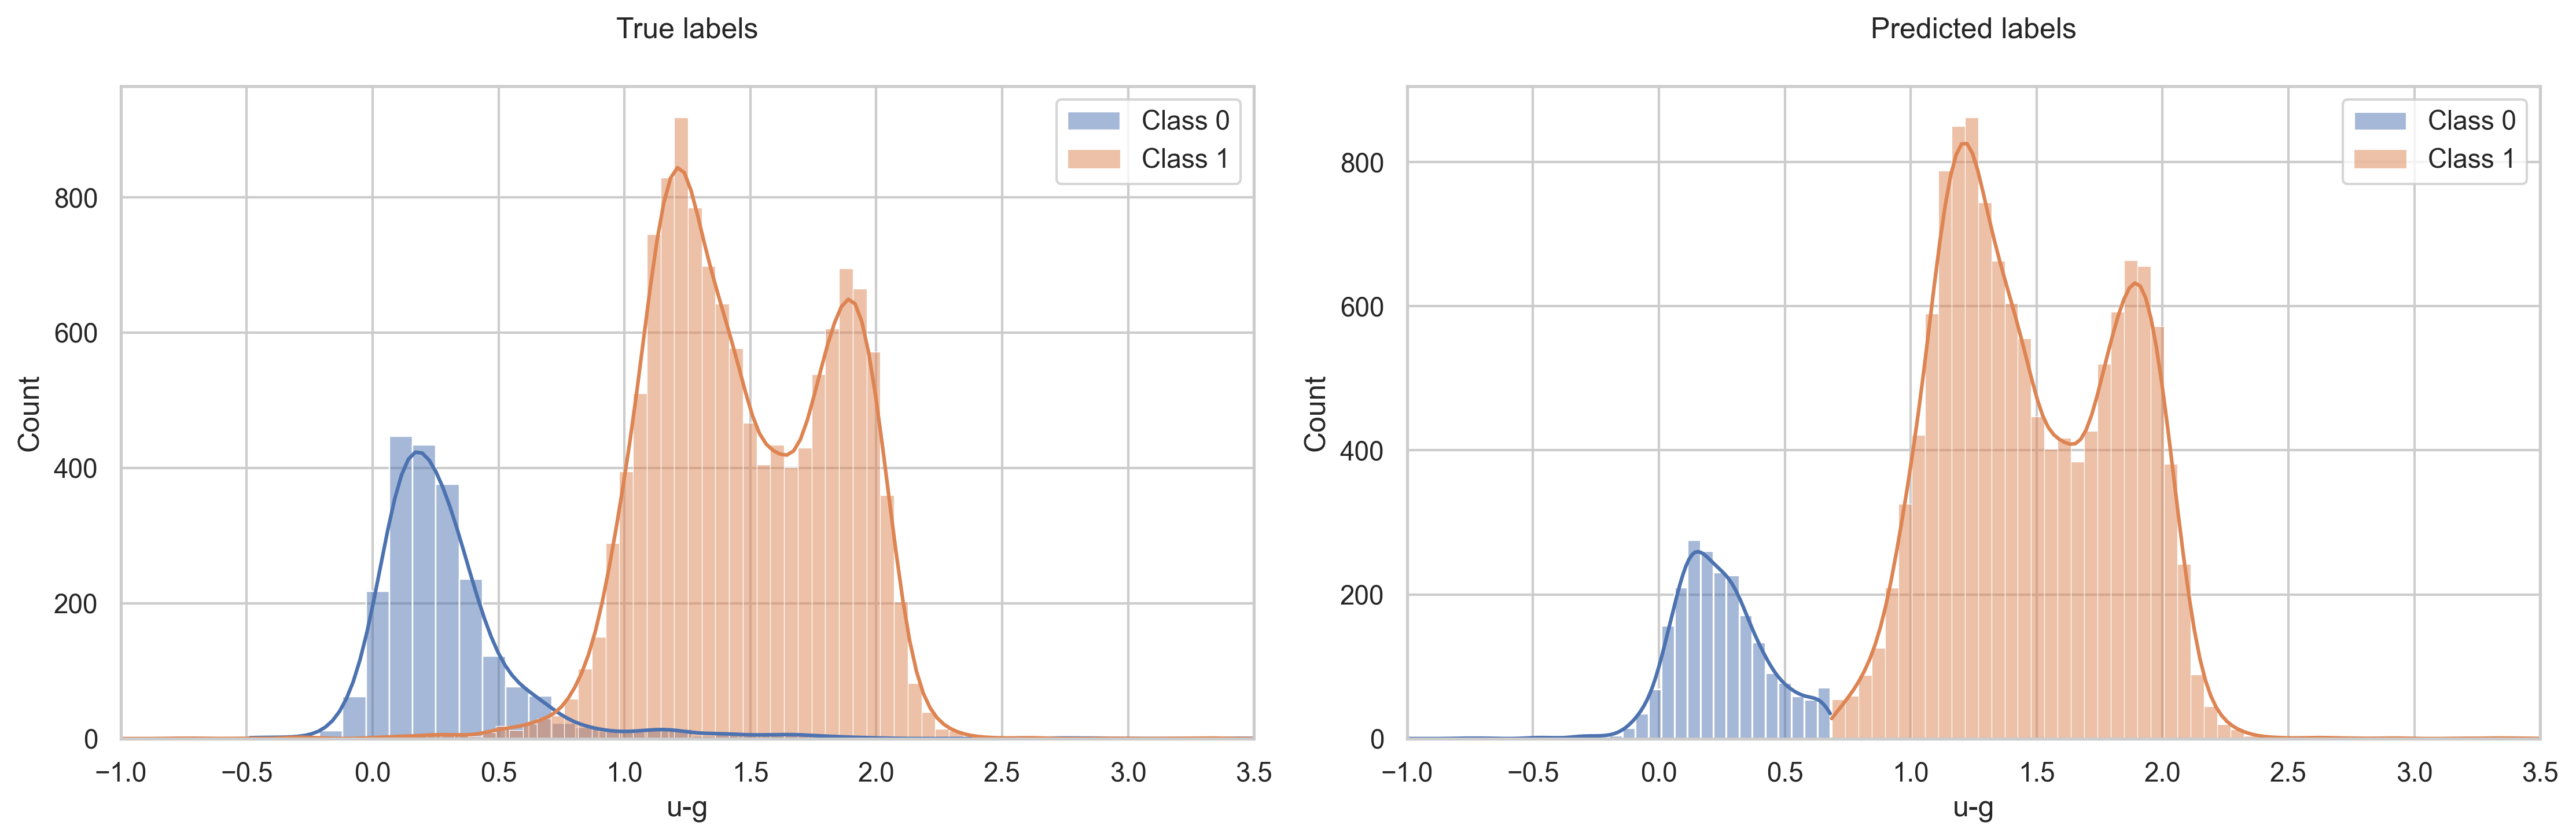

In [184]:
plt.figure(figsize=(15, 5))

# --- Left: True Labels ---
plt.subplot(1, 2, 1)
for label in np.unique(y_test):
    sns.histplot(
        X_test[y_test == label, 0],
        label=f"Class {label}",
        bins='scott',
        kde=True,
        stat="count",
        element="bars",
        common_norm=False
    )
plt.title('True labels')
plt.xlabel('u-g')
plt.ylabel('Count')
plt.xlim(-1, 3.5)
plt.legend()

# --- Right: Predicted Labels ---
plt.subplot(1, 2, 2)
for label in np.unique(predicted):
    sns.histplot(
        X_test[predicted == label, 0],
        label=f"Class {label}",
        bins='scott',
        kde=True,
        stat="count",
        element="bars",
        common_norm=False
    )
plt.title('Predicted labels')
plt.xlabel('u-g')
plt.ylabel('Count')
plt.xlim(-1, 3.5)
plt.legend()

plt.tight_layout()
plt.show()


In [185]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming binary classification with labels 0 and 1
cm = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 12684
True Negatives (TN): 2037
False Positives (FP): 151
False Negatives (FN): 128


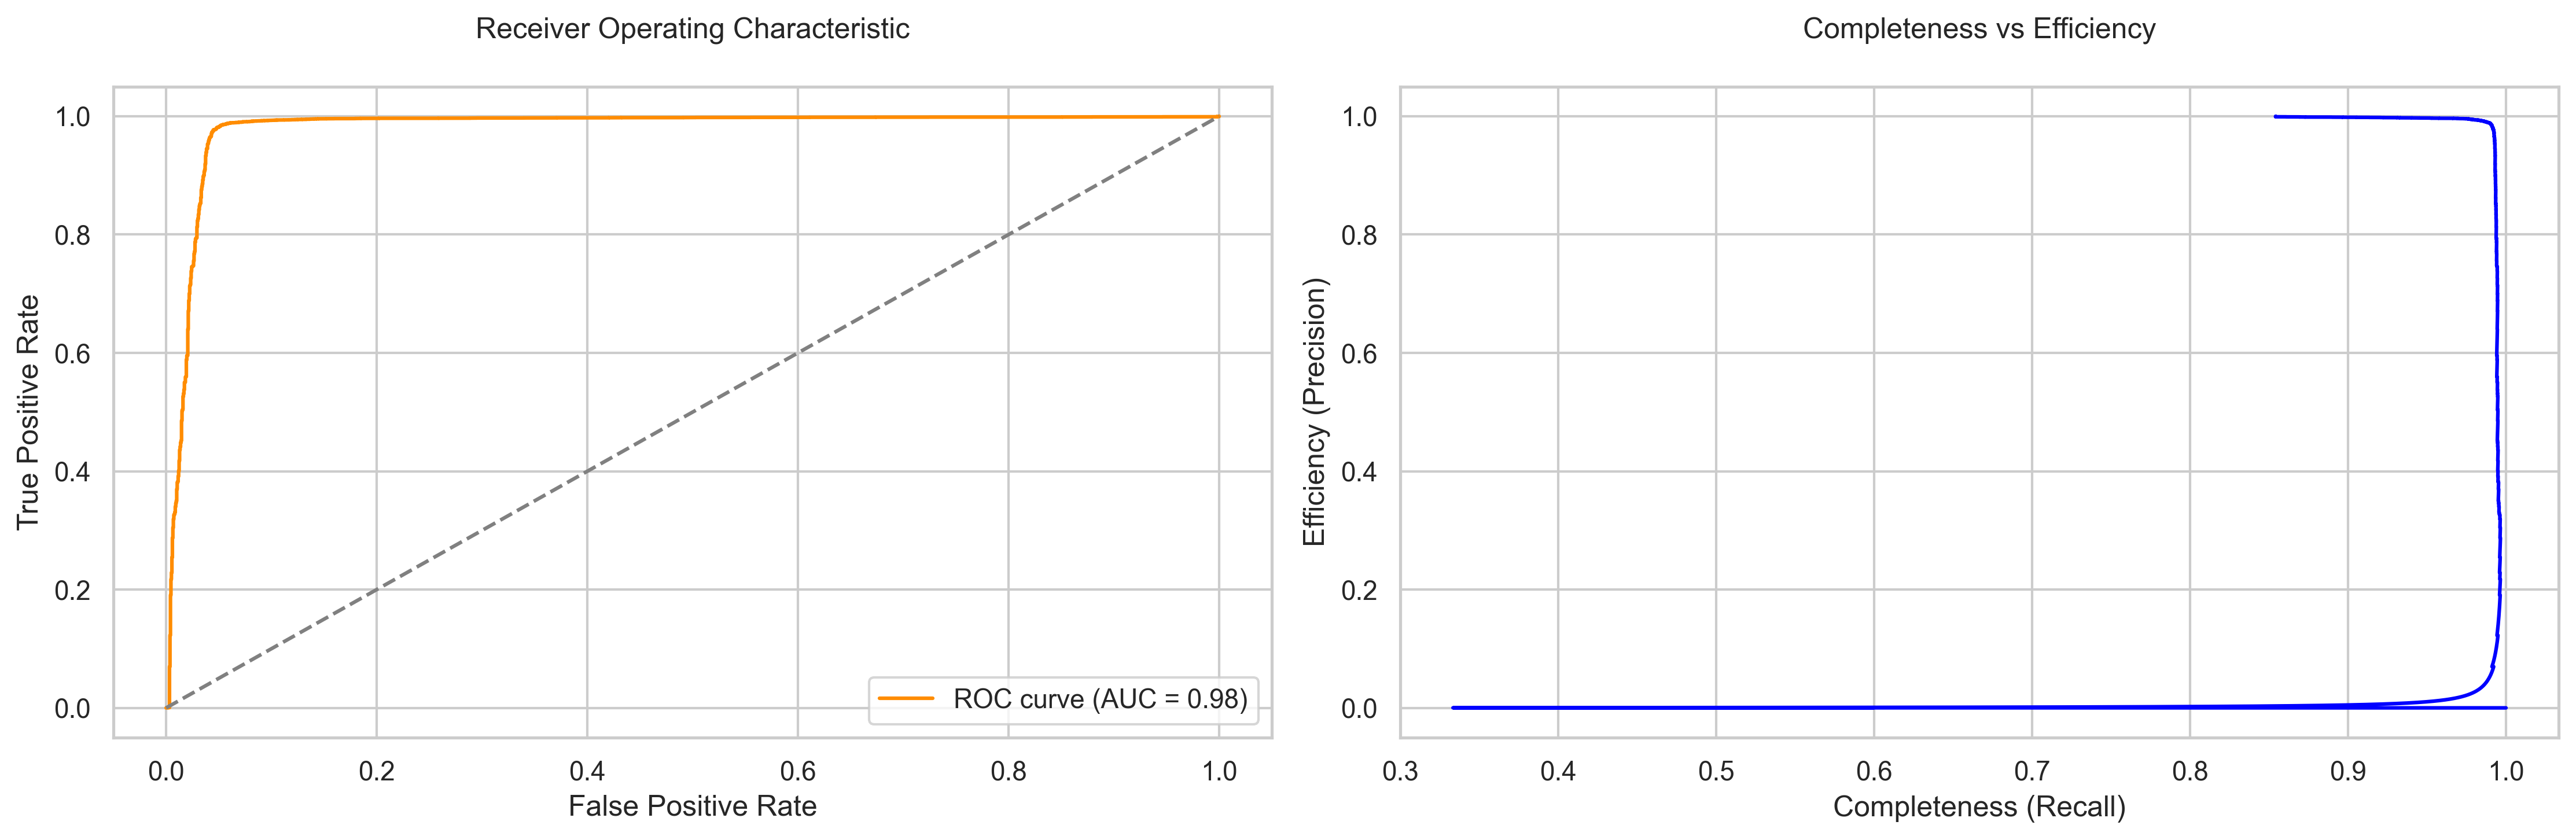

In [186]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for class 1
y_scores = GNB.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(precision, recall, color='blue')
plt.xlabel('Completeness (Recall)')
plt.ylabel('Efficiency (Precision)')
plt.title('Completeness vs Efficiency')
plt.grid(True)

plt.tight_layout()

Comment on TP vs FP plot:
- AUC ≈ 0.98, which indicates excellent separability between the two classes.
- The curve quickly rises to a True Positive Rate (TPR) close to 1 while keeping the False Positive Rate (FPR) near 0, which means the model rarely misclassifies negatives as positives.
- The ROC curve being far above the diagonal (random guess line) shows your classifier is performing significantly better than chance.
Thus this model can effectively distinguish between the two classes over a wide range of thresholds.

Comment on Eff vs Comp:
- The curve shape is sharp and vertical near the top right corner.
- For most of the recall range $0.3–0.99$, the precision remains extremely low, close to zero.
- Only at very high recall $1.0$ does precision (efficiency) shoot up — indicating a precision-recall imbalance.
**The model ranks positives well (high ROC AUC), but actual predictions (e.g., at default threshold 0.5) may lead to many false positives.**

\
Maybe this is due to class imbalance

In [187]:
print(f'QSO true labels over total number of labels : {len(y_train[y_train==1])/len(y_train)*100 :.3} %')

QSO true labels over total number of labels : 85.9 %


Yes, I do have heavily imbalanced classes. I have to see what happens if I take into account classes imbalances by resampling

In [188]:
from sklearn.utils import resample

X_y_train = np.hstack((X_train, y_train.reshape(-1, 1)))

# Separate majority and minority classes
majority = X_y_train[y_train == 1]
minority = X_y_train[y_train == 0]

# Downsample majority class to match minority
majority_downsampled = resample(majority,
                                replace=False,
                                n_samples=len(minority),
                                random_state=42)

# Combine
balanced = np.vstack((majority_downsampled, minority))
np.random.shuffle(balanced)

# Split back to X and y
X_train_balanced = balanced[:, :-1]
y_train_balanced = balanced[:, -1]

In [189]:
len(y_train_balanced[y_train_balanced==0])/len(y_train_balanced)

0.5

In [190]:
GNB = GaussianNB()
GNB.fit(X_train_balanced, y_train_balanced)
predicted = GNB.predict(X_test)

In [191]:
cm = confusion_matrix(y_test, predicted)
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 12472
True Negatives (TN): 2092
False Positives (FP): 96
False Negatives (FN): 340


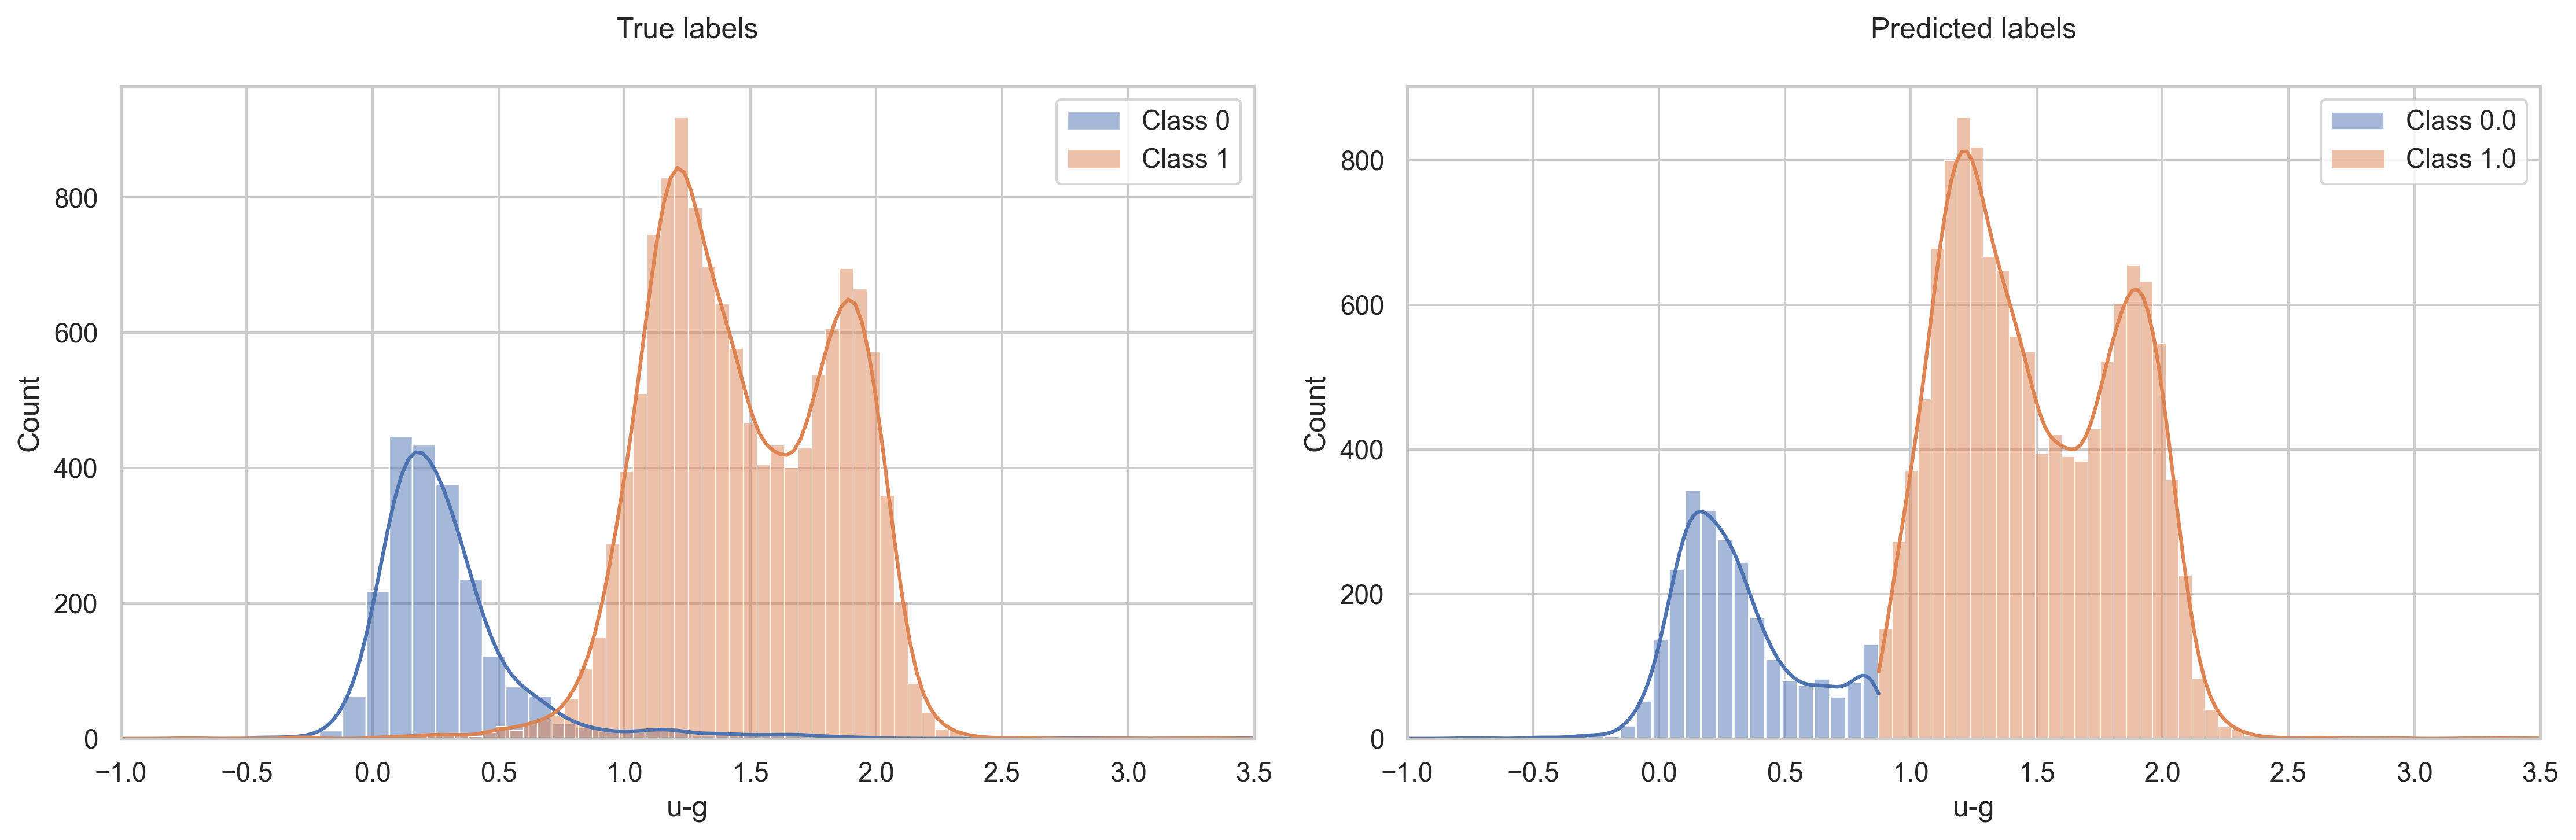

In [192]:
plt.figure(figsize=(15, 5))

# --- Left: True Labels ---
plt.subplot(1, 2, 1)
for label in np.unique(y_test):
    sns.histplot(
        X_test[y_test == label, 0],
        label=f"Class {label}",
        bins='scott',
        kde=True,
        stat="count",
        element="bars",
        common_norm=False
    )
plt.title('True labels')
plt.xlabel(df.columns[col])
plt.ylabel('Count')
plt.xlim(-1, 3.5)
plt.legend()

# --- Right: Predicted Labels ---
plt.subplot(1, 2, 2)
for label in np.unique(predicted):
    sns.histplot(
        X_test[predicted == label, 0],
        label=f"Class {label}",
        bins='scott',
        kde=True,
        stat="count",
        element="bars",
        common_norm=False
    )
plt.title('Predicted labels')
plt.xlabel(df.columns[col])
plt.ylabel('Count')
plt.xlim(-1, 3.5)
plt.legend()

plt.tight_layout()
plt.show()


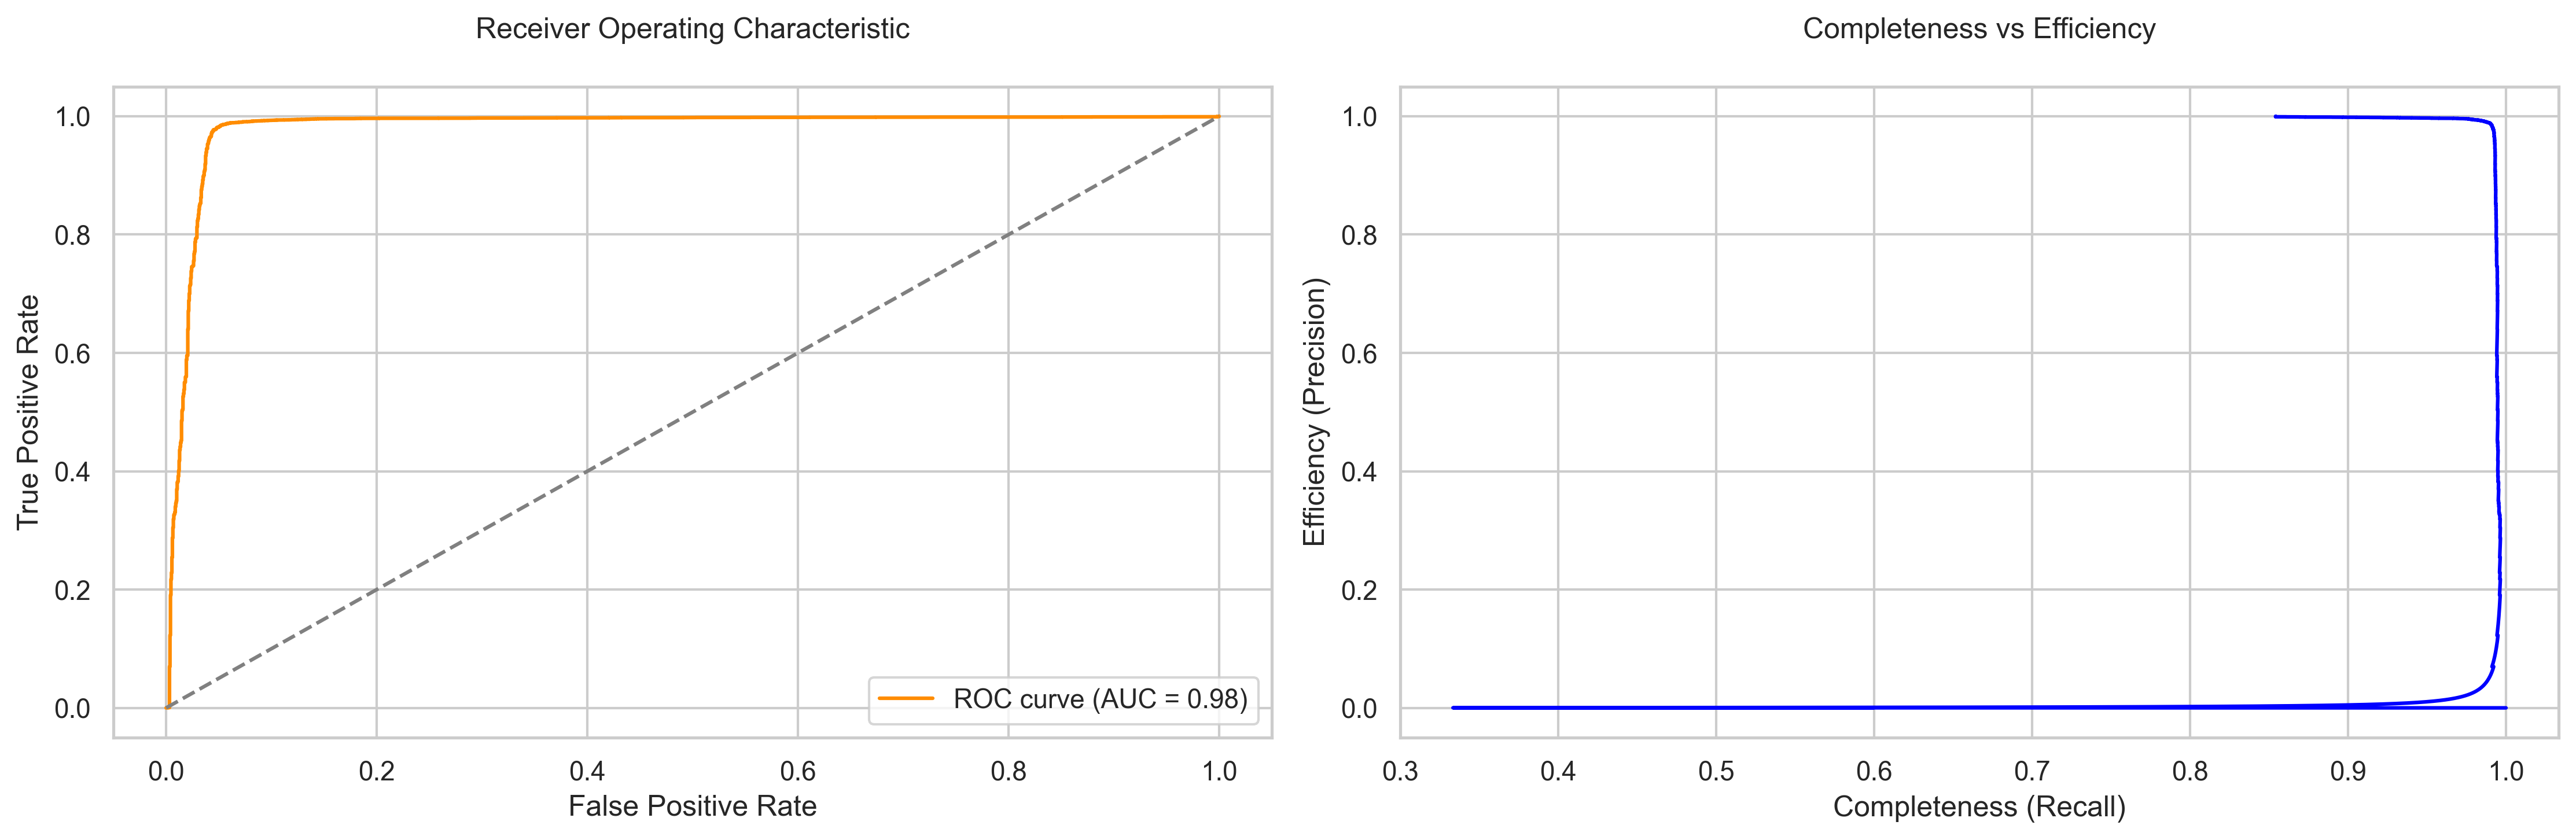

In [193]:
# Get predicted probabilities for class 1
y_scores = GNB.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(precision, recall, color='blue')
plt.xlabel('Completeness (Recall)')
plt.ylabel('Efficiency (Precision)')
plt.title('Completeness vs Efficiency')
plt.grid(True)

plt.tight_layout()

## Generative 4D Classification : Gaussian Naive Bayes

Could using more features help?

In [250]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

# Use your original DataFrame and target column name here:
X = df.drop(columns=['class'])  # Replace 'target_col' with your actual label column name
y = Y

features = X.columns.tolist()
custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_test, X_cv, y_test, y_cv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

scores_cv, scores_test, roc_curves, precisions, recalls = [], [], [], [], []

for i in range(1, len(features) + 1):
    selected_features = features[:i]
    model = GaussianNB()

    score_cv = cross_val_score(model, X_cv[selected_features], y_cv, cv=custom_cv, scoring='roc_auc').mean()
    scores_cv.append(score_cv)

    model.fit(X_train[selected_features], y_train)
    y_prob_test = model.predict_proba(X_test[selected_features])[:, 1]
    score_test = roc_auc_score(y_test, y_prob_test)
    scores_test.append(score_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_curves.append((fpr, tpr, score_test, i))

    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    precisions.append(precision)
    recalls.append(recall)

print("CV ROC AUC scores:", scores_cv)
print("Test ROC AUC scores:", scores_test)

CV ROC AUC scores: [np.float64(0.9785406262091927), np.float64(0.9741000082325476), np.float64(0.9742281391987916), np.float64(0.9744891534541738)]
Test ROC AUC scores: [0.9810934827044432, 0.9785813486167172, 0.978204510333921, 0.9781333661086677]


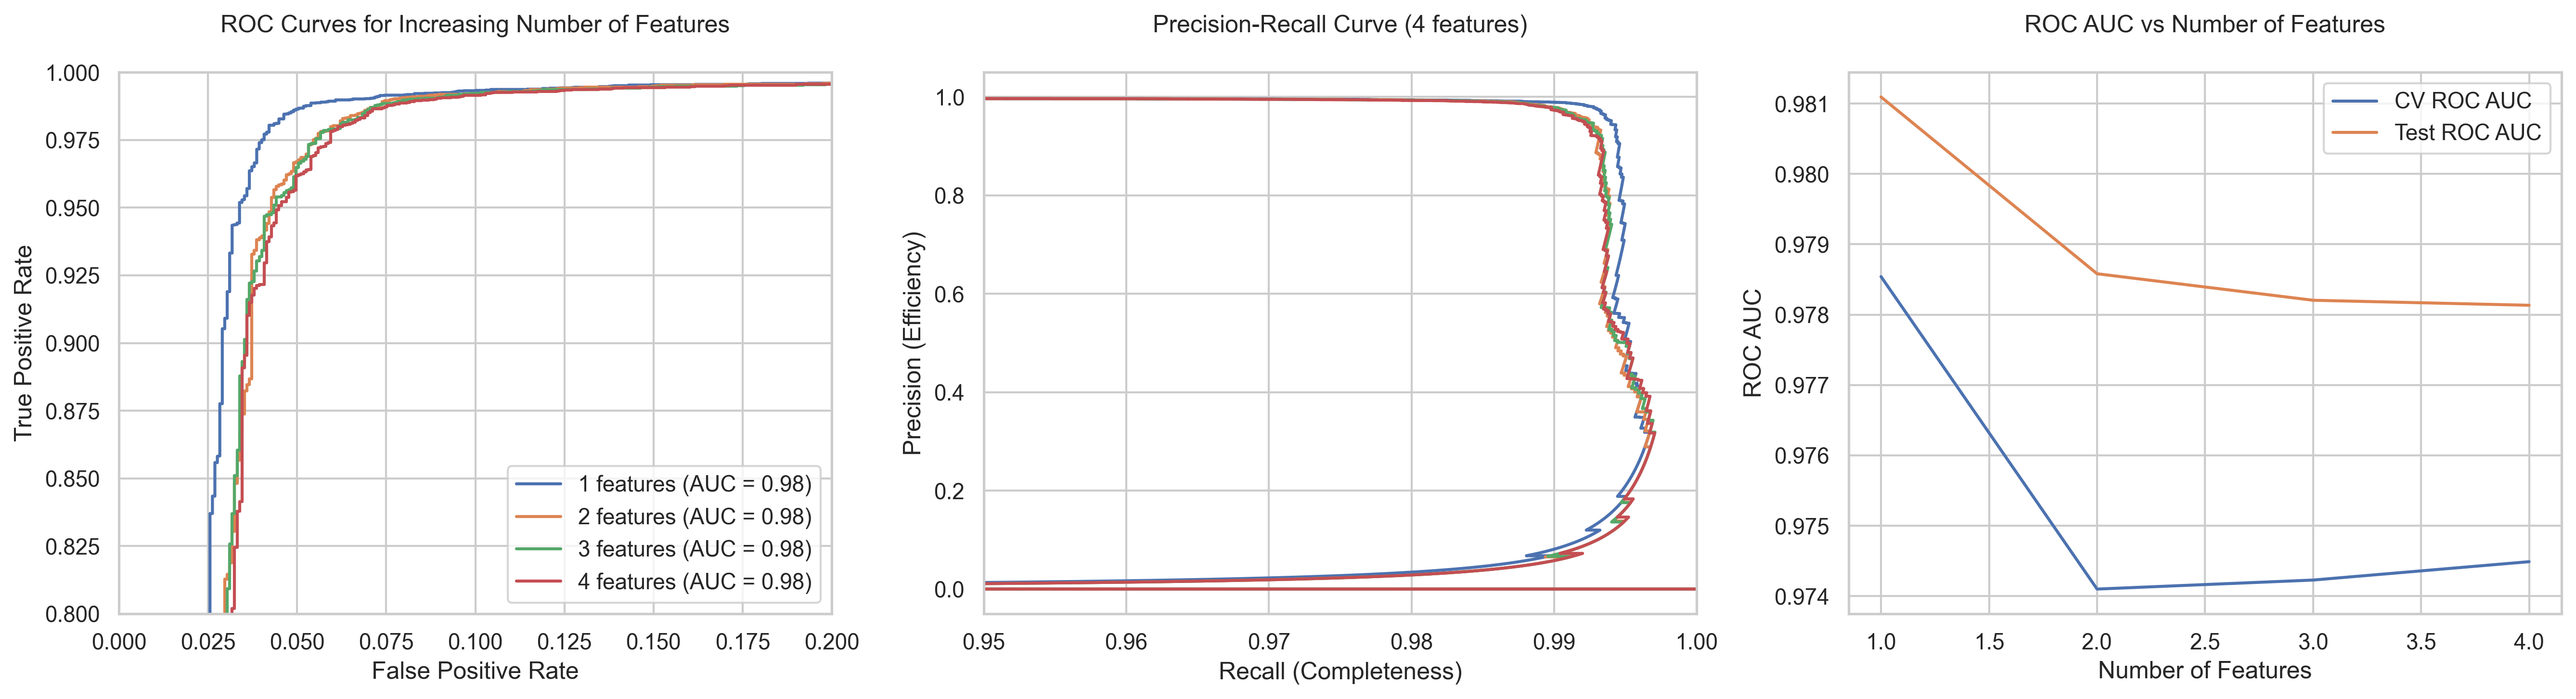

In [254]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

plt.figure(figsize=(18, 5))  # bigger figure for 3 subplots side by side

# 1) ROC curves for all feature sets
plt.subplot(1, 3, 1)
for fpr, tpr, auc_score, n_features in roc_curves:
    plt.plot(fpr, tpr, label=f'{n_features} features (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Increasing Number of Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1)

# 2) Precision-Recall curve for last feature set

plt.subplot(1, 3, 2)
for n, (r, p) in enumerate(zip(precisions, recalls)):
    plt.plot(r, p, label=f'{n} features')
plt.xlabel('Recall (Completeness)')
plt.ylabel('Precision (Efficiency)')
plt.title(f'Precision-Recall Curve ({len(features)} features)')
plt.grid(True)
plt.xlim(0.95, 1)

plt.subplot(1, 3, 3)
plt.plot(range(1, len(features) + 1), scores_cv, label='CV ROC AUC')
plt.plot(range(1, len(features) + 1), scores_test, label='Test ROC AUC')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Number of Features')
plt.legend()
plt.grid(True)

plt.tight_layout()

This means that as far as Gaussian Naive Bayes goes, 1 feature is enough!

## Another model : K-Nearest Neighbors

In [260]:
from sklearn.neighbors import KNeighborsClassifier

# Use your original DataFrame and target column name here:
X = df.drop(columns=['class'])  # Replace 'target_col' with your actual label column name
y = Y

features = X.columns.tolist()
custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_test, X_cv, y_test, y_cv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


Ks = [5, 10, 100, 1000]
for k in Ks:
    print(f'Neigh : {k}')
    scores_cv, scores_test, roc_curves, precisions, recalls = [], [], [], [], []
    for i in range(1, len(features) + 1):
        selected_features = features[:i]
        model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        model.fit(X_train[selected_features], y_train)
        score_cv = cross_val_score(model, X_cv[selected_features], y_cv, cv=custom_cv, scoring='roc_auc').mean()
        scores_cv.append(score_cv)

        y_prob_test = model.predict_proba(X_test[selected_features])[:, 1]
        score_test = roc_auc_score(y_test, y_prob_test)
        scores_test.append(score_test)

        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_curves.append((fpr, tpr, score_test, i))

        precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
        precisions.append(precision)
        recalls.append(recall)

    print("CV ROC AUC scores:", scores_cv)
    print("Test ROC AUC scores:", scores_test)

Neigh : 5
CV ROC AUC scores: [np.float64(0.9655354069573635), np.float64(0.9731380176277009), np.float64(0.9756574467782022), np.float64(0.9787408648215049)]
Test ROC AUC scores: [0.9745090886949646, 0.979424379422086, 0.9830324252929107, 0.9834720093907148]
Neigh : 10
CV ROC AUC scores: [np.float64(0.9677710810679685), np.float64(0.9778247727147356), np.float64(0.9818542847401865), np.float64(0.9825101990637195)]
Test ROC AUC scores: [0.9770337396441142, 0.9838364923199767, 0.9859012495542382, 0.9864117759924338]
Neigh : 100
CV ROC AUC scores: [np.float64(0.9725680585950933), np.float64(0.9875529477618201), np.float64(0.9893682819582622), np.float64(0.9896842890751032)]
Test ROC AUC scores: [0.980327208523482, 0.9888532907555467, 0.9913126117634594, 0.9934374903095265]
Neigh : 1000
CV ROC AUC scores: [np.float64(0.974716237644443), np.float64(0.9886857617518408), np.float64(0.9902386222406973), np.float64(0.9905998439018537)]
Test ROC AUC scores: [0.9791957650047289, 0.990878195918114

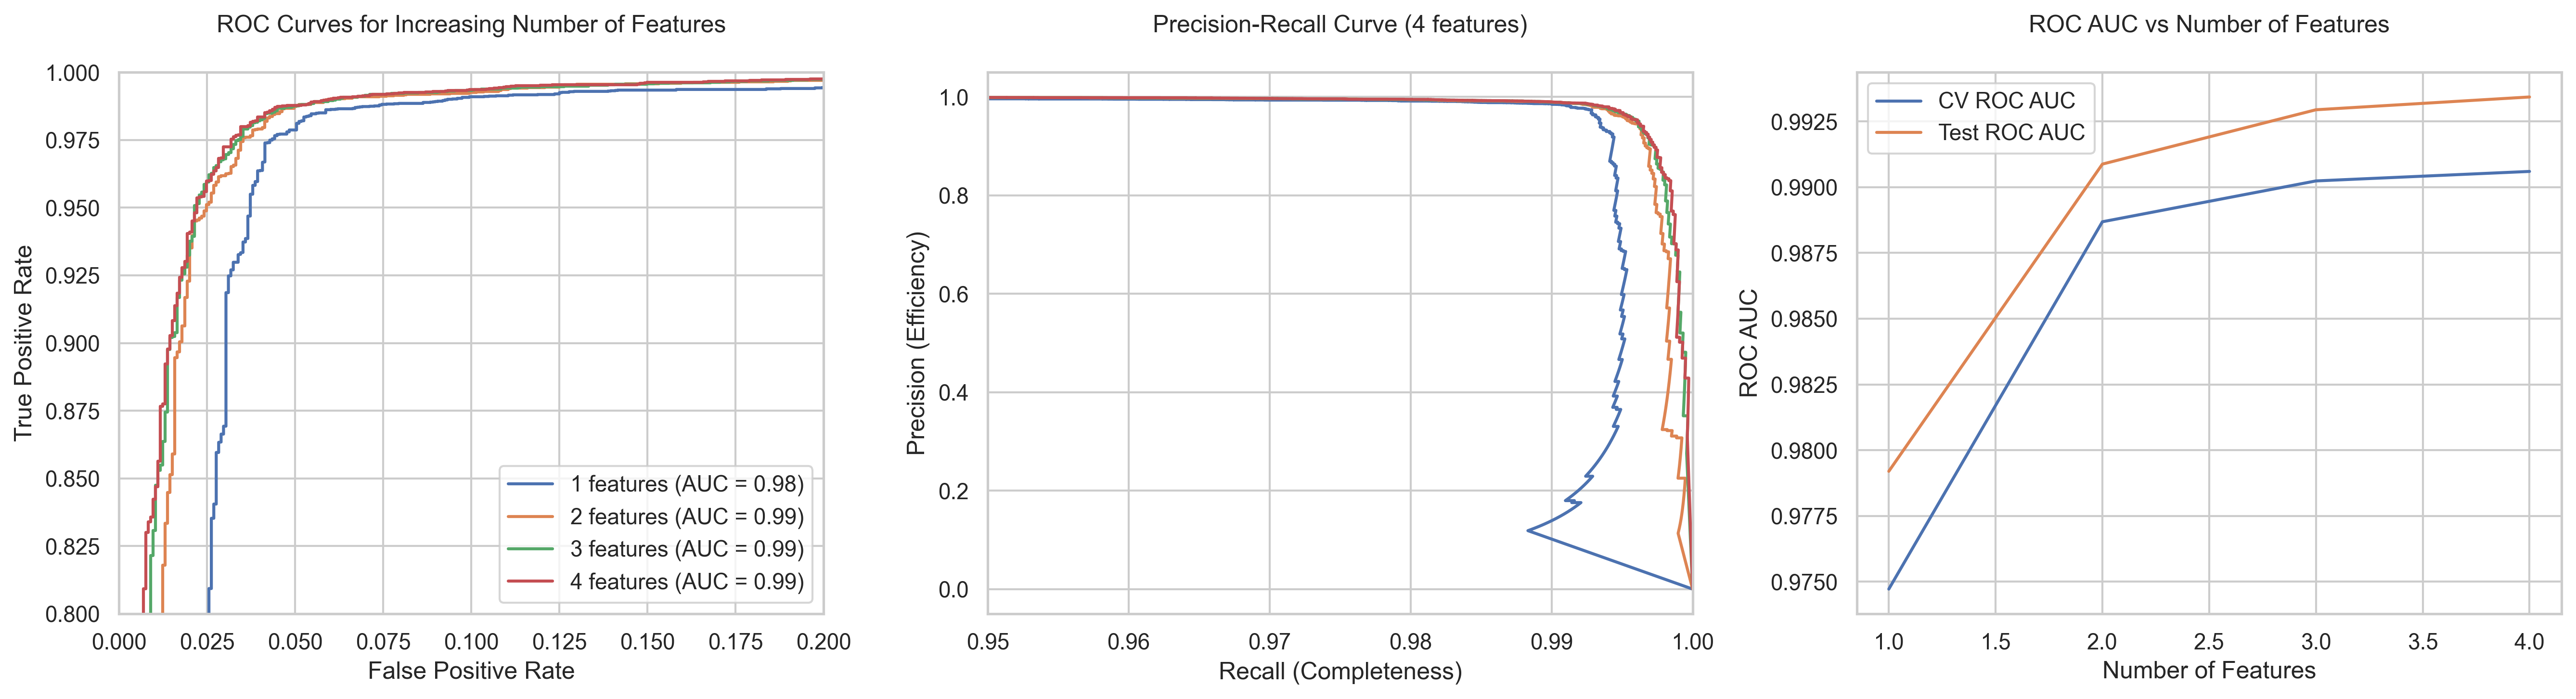

In [261]:
plt.figure(figsize=(18, 5))  # bigger figure for 3 subplots side by side

# 1) ROC curves for all feature sets
plt.subplot(1, 3, 1)
for fpr, tpr, auc_score, n_features in roc_curves:
    plt.plot(fpr, tpr, label=f'{n_features} features (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Increasing Number of Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1)

# 2) Precision-Recall curve for last feature set

plt.subplot(1, 3, 2)
for n, (r, p) in enumerate(zip(precisions, recalls)):
    plt.plot(r, p, label=f'{n} features')
plt.xlabel('Recall (Completeness)')
plt.ylabel('Precision (Efficiency)')
plt.title(f'Precision-Recall Curve ({len(features)} features)')
plt.grid(True)
plt.xlim(0.95, 1)

plt.subplot(1, 3, 3)
plt.plot(range(1, len(features) + 1), scores_cv, label='CV ROC AUC')
plt.plot(range(1, len(features) + 1), scores_test, label='Test ROC AUC')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Number of Features')
plt.legend()
plt.grid(True)

plt.tight_layout()